In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

## Kobe Bryant  shot selection

Cсылка на соревнование: https://www.kaggle.com/c/kobe-bryant-shot-selection

Goal: Fun and education

Using 20 years of data on Kobe's swishes and misses, can you predict which shots will find the bottom of the net? This competition is well suited for practicing classification basics, feature engineering, and time series analysis. Practice got Kobe an eight-figure contract and 5 championship rings. What will it get you?

This data contains the location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career. Your task is to predict whether the basket went in (shot_made_flag).

We have removed 5000 of the shot_made_flags (represented as missing values in the csv file). These are the test set shots for which you must submit a prediction. You are provided a sample submission file with the correct shot_ids needed for a valid prediction.

In [2]:
data = pd.read_csv('data/Kobe.csv')

In [3]:
data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [4]:
target = 'shot_made_flag'

**Задания:**

1. Провести анализ данных. Много хороших примеров анализа можно посмотреть здесь https://www.kaggle.com/c/kobe-bryant-shot-selection/kernels
2. Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.
3. Обучить линейную модель, Lasso, Ridge на тех же признаках - построить сравнительную таблицу коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются. Посчитать RSS

**Дополнительно**
4. Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC
5. Построить PCA на подготовленных признаках, посмотреть, какие компоненты составляют наибольшую часть дисперсии целевой переменной

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
action_type           30697 non-null object
combined_shot_type    30697 non-null object
game_event_id         30697 non-null int64
game_id               30697 non-null int64
lat                   30697 non-null float64
loc_x                 30697 non-null int64
loc_y                 30697 non-null int64
lon                   30697 non-null float64
minutes_remaining     30697 non-null int64
period                30697 non-null int64
playoffs              30697 non-null int64
season                30697 non-null object
seconds_remaining     30697 non-null int64
shot_distance         30697 non-null int64
shot_made_flag        25697 non-null float64
shot_type             30697 non-null object
shot_zone_area        30697 non-null object
shot_zone_basic       30697 non-null object
shot_zone_range       30697 non-null object
team_id               30697 non-null int64
team_name         

In [60]:
# Удаляем строки с пустым целевым атрибутом
df = data.dropna(subset=['shot_made_flag']).reset_index()

In [61]:
# преобразуем в нормальное время
df['dt_game_date'] = pd.to_datetime(df['game_date'])

In [62]:
# честно утянул с kaggle
# в конвеер воткнуть не получится, т.к. на их основе будем разбивать на train и test
df['secondsFromPeriodEnd']   = 60*df['minutes_remaining']+df['seconds_remaining']
df['secondsFromPeriodStart'] = 60*(11-df['minutes_remaining'])+(60-df['seconds_remaining'])
df['secondsFromGameStart']   = (df['period'] <= 4).astype(int)*(df['period']-1)*12*60 + (df['period'] > 4).astype(int)*((df['period']-4)*5*60 + 3*12*60) + df['secondsFromPeriodStart']

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25697 entries, 0 to 25696
Data columns (total 30 columns):
index                     25697 non-null int64
action_type               25697 non-null object
combined_shot_type        25697 non-null object
game_event_id             25697 non-null int64
game_id                   25697 non-null int64
lat                       25697 non-null float64
loc_x                     25697 non-null int64
loc_y                     25697 non-null int64
lon                       25697 non-null float64
minutes_remaining         25697 non-null int64
period                    25697 non-null int64
playoffs                  25697 non-null int64
season                    25697 non-null object
seconds_remaining         25697 non-null int64
shot_distance             25697 non-null int64
shot_made_flag            25697 non-null float64
shot_type                 25697 non-null object
shot_zone_area            25697 non-null object
shot_zone_basic           25697 no

In [11]:
df.describe()

,index,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,shot_made_flag,team_id,shot_id,secondsFromPeriodEnd,secondsFromPeriodStart,secondsFromGameStart
count,25697.000000,25697.000000,2.569700e+04,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,2.569700e+04,25697.000000,25697.000000,25697.000000,25697.000000
mean,15327.166946,249.348679,2.474109e+07,33.953043,7.148422,91.257345,-118.262652,4.886796,2.520800,0.146243,28.311554,13.457096,0.446161,1.610613e+09,15328.166946,321.519321,398.480679,1487.556446
std,8860.462397,149.778520,7.738108e+06,0.088152,110.073147,88.152106,0.110073,3.452475,1.151626,0.353356,17.523392,9.388725,0.497103,0.000000e+00,8860.462397,208.311076,208.311076,851.005173
min,1.000000,2.000000,2.000001e+07,33.253300,-250.000000,-44.000000,-118.519800,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.610613e+09,2.000000,0.000000,6.000000,6.000000
25%,7645.000000,111.000000,2.050006e+07,33.884300,-67.000000,4.000000,-118.336800,2.000000,1.000000,0.000000,13.000000,5.000000,0.000000,1.610613e+09,7646.000000,141.000000,221.000000,709.000000
50%,15335.000000,253.000000,2.090034e+07,33.970300,0.000000,74.000000,-118.269800,5.000000,3.000000,0.000000,28.000000,15.000000,0.000000,1.610613e+09,15336.000000,304.000000,416.000000,1502.000000
75%,22975.000000,367.000000,2.960027e+07,34.040300,94.000000,160.000000,-118.175800,8.000000,3.000000,0.000000,43.000000,21.000000,1.000000,1.610613e+09,22976.000000,499.000000,579.000000,2160.000000
max,30696.000000,653.000000,4.990009e+07,34.088300,248.000000,791.000000,-118.021800,11.000000,7.000000,1.000000,59.000000,79.000000,1.000000,1.610613e+09,30697.000000,714.000000,720.000000,3766.000000


In [47]:
df['coord'] = df['lat'].astype(str) + ', ' + df['lon'].astype(str)
df.coord.value_counts()

34.0443, -118.2698    4321
34.0433, -118.2698      16
34.0443, -118.2708       9
34.0433, -118.2688       8
34.0433, -118.2518       7
33.9813, -118.2688       6
34.0443, -118.2848       6
34.0443, -118.2678       6
34.0443, -118.1108       6
34.0443, -118.2858       6
34.0443, -118.1288       5
33.9343, -118.1318       5
34.0443, -118.2718       5
34.0403, -118.2858       5
34.0523, -118.1338       5
34.0333, -118.2698       5
34.0333, -118.2738       5
34.0323, -118.2468       5
34.0383, -118.2628       5
34.0473, -118.1208       5
34.0383, -118.2528       5
33.9833, -118.2348       5
33.8353, -118.4278       5
34.0353, -118.2698       5
34.0443, -118.2468       5
34.0413, -118.2718       5
33.9123, -118.1618       5
33.8583, -118.4468       5
34.0303, -118.2528       5
34.0403, -118.2588       5
                      ... 
33.9363, -118.1448       1
33.8573, -118.1748       1
33.9303, -118.1618       1
33.9443, -118.5098       1
33.9203, -118.2498       1
34.0373, -118.4528       1
3

На координаты расчитывать не стоит - некоторые из них указывают в море-окиян

In [27]:
# в тестовый набор поместим наиболее поздние броски
def split_train_test(data, test_ratio):
    test_count = round(len(data) * test_ratio)
    train_count = len(data) - test_count
    return data.sort_values(by=['dt_game_date', 'secondsFromGameStart'], ascending=False).tail(train_count).reset_index(), \
           data.sort_values(by=['dt_game_date', 'secondsFromGameStart'], ascending=False).head(test_count).reset_index()
           

In [28]:
train_data, test_data = split_train_test(df, 0.2)
len(train_data), len(test_data)

(20558, 5139)

In [53]:
df.shot_type.value_counts()

2PT Field Goal    20285
3PT Field Goal     5412
Name: shot_type, dtype: int64

In [78]:
class ColumnsRemover(BaseEstimator, TransformerMixin):
    def __init__(self, columns=[]):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(columns=self.columns)

In [79]:
p = Pipeline([('col_remover', ColumnsRemover(['lat', 'lon', 'team_id', 'team_name', 'season', 'game_id', 'game_event_id']))])

In [81]:
df = p.fit_transform(df)

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25697 entries, 0 to 25696
Data columns (total 23 columns):
index                     25697 non-null int64
action_type               25697 non-null object
combined_shot_type        25697 non-null object
loc_x                     25697 non-null int64
loc_y                     25697 non-null int64
minutes_remaining         25697 non-null int64
period                    25697 non-null int64
playoffs                  25697 non-null int64
seconds_remaining         25697 non-null int64
shot_distance             25697 non-null int64
shot_made_flag            25697 non-null float64
shot_type                 25697 non-null object
shot_zone_area            25697 non-null object
shot_zone_basic           25697 non-null object
shot_zone_range           25697 non-null object
game_date                 25697 non-null object
matchup                   25697 non-null object
opponent                  25697 non-null object
shot_id                   25697 no

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001ADA9F80358>,
      dtype=object)

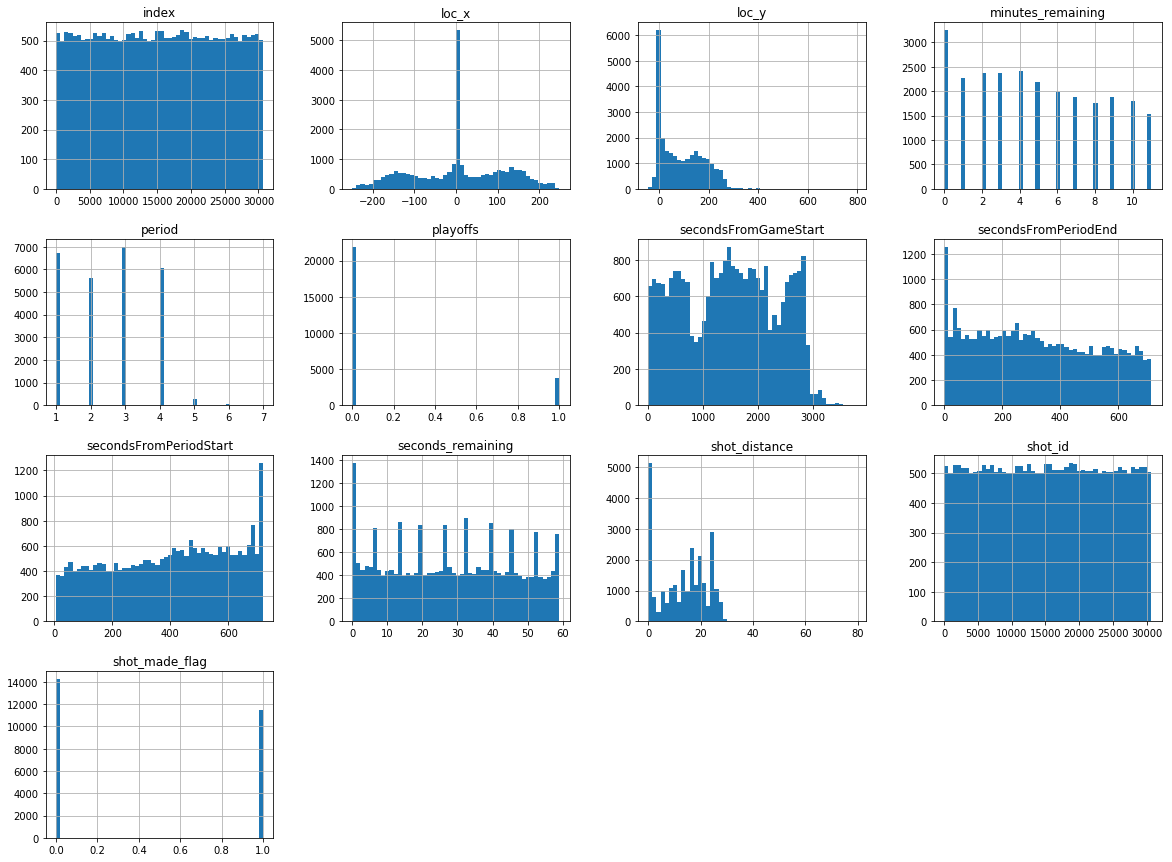

In [83]:
df.hist(bins=50, figsize=(20,15))